# 악성 댓글 구분하기

In [ ]:
!pip install transformers
!pip install datasets==1.17.0

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

### 데이터 읽어오기

In [ ]:
from datasets import load_dataset
datasets = load_dataset('smilegate-ai/kor_unsmile')

In [4]:
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 15005
    })
    valid: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 3737
    })
})


In [5]:
import pandas as pd

In [6]:
train_df = pd.DataFrame(datasets["train"])
valid_df = pd.DataFrame(datasets["valid"])
train_df.shape, valid_df.shape

((15005, 13), (3737, 13))

### 데이터 전처리

In [7]:
train_df.isna().sum()

문장        0
여성/가족     0
남성        0
성소수자      0
인종/국적     0
연령        0
지역        0
종교        0
기타 혐오     0
악플/욕설     0
clean     0
개인지칭      0
labels    0
dtype: int64

In [8]:
valid_df.isna().sum()

문장        0
여성/가족     0
남성        0
성소수자      0
인종/국적     0
연령        0
지역        0
종교        0
기타 혐오     0
악플/욕설     0
clean     0
개인지칭      0
labels    0
dtype: int64

In [9]:
# train_df shape : (15005, 13) 이므로 중복 1개 존재
train_df.문장.nunique()

15004

In [10]:
# valid df shape : (3737, 13) 중복이 존재하지 않음
valid_df.문장.nunique()

3737

In [11]:
train_df.drop_duplicates(subset=['문장'], inplace=True) 
train_df.shape

(15004, 13)

In [12]:
# 악성댓글이면 0, 아니면 1
train_df.clean.value_counts()

0    11266
1     3738
Name: clean, dtype: int64

In [13]:
valid_df.clean.value_counts()

0    2802
1     935
Name: clean, dtype: int64

### 텍스트 전처리

In [14]:
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

In [15]:
train_df.문장 = train_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
train_df.문장.replace('', np.nan, inplace=True)
train_df.dropna(how='any', inplace=True)
train_df.shape
# 24개 제거

(14980, 13)

In [16]:
valid_df.문장 = valid_df.문장.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ').str.strip()
valid_df.문장.replace('', np.nan, inplace=True)
valid_df.dropna(how='any', inplace=True)
valid_df.shape
# 7개 제거

(3730, 13)

### 형태소 분석 & 정수 인코딩


#### Tokenizer : Mecab

In [18]:
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

mecab = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']

In [79]:
X_train = []
for sentence in tqdm(train_df.문장):
    morphs = mecab.morphs(sentence)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_train.append(tmp_X)

  0%|          | 0/14980 [00:00<?, ?it/s]

In [80]:
X_test = []
for sentence in tqdm(valid_df.문장):
    morphs = mecab.morphs(sentence)
    tmp_X = [word for word in morphs if word not in stopwords]
    X_test.append(tmp_X)

  0%|          | 0/3730 [00:00<?, ?it/s]

In [81]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

threshold = 10
total_cnt = len(t.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in t.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 19678
등장 빈도가 9번 이하인 희귀 단어의 수: 17065
단어 집합에서 희귀 단어의 비율: 86.72121150523428
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 15.053223913647464


In [82]:
# 모든 단어를 사용하기로 결정
vocab_size = total_cnt + 2
print(vocab_size)

19680


In [83]:
t = Tokenizer()
t.fit_on_texts(X_train)
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
y_train = np.array(train_df[['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']])
y_test = np.array(valid_df[['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']])

y_train.shape, y_test.shape

((14980, 10), (3730, 10))

In [84]:
# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

14978
14978


### 패딩

리뷰의 최대 길이_Mecab ver : 74
리뷰의 평균 길이_Mecab ver : 16.100347175857927


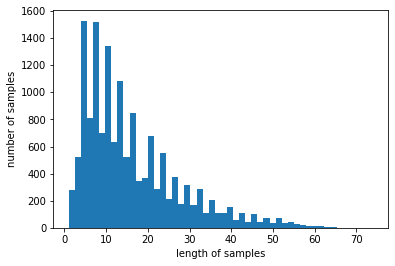

In [85]:
import matplotlib.pyplot as plt
print('리뷰의 최대 길이_Mecab ver :',max(len(review) for review in X_train))
print('리뷰의 평균 길이_Mecab ver :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [86]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [90]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.22406195753773


In [91]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((14978, 50), (3730, 50))

### 모델 생성 및 분류하기

#### 1. LSTM

In [92]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [93]:
model1 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(128),
    Dense(10, activation='softmax')
])
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 128)           2519040   
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,651,914
Trainable params: 2,651,914
Non-trainable params: 0
_________________________________________________________________


In [94]:
model1.compile('adam', 'categorical_crossentropy', ['accuracy'])
model1_path = 'unsmile_lstm.h5'
mc1 = ModelCheckpoint(model1_path, verbose=1, save_best_only=True)
es1 = EarlyStopping(patience=5)

In [95]:
hist1 = model1.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc1, es1]
)

Epoch 1/100
187/188 [============================>.] - ETA: 0s - loss: 2.1083 - accuracy: 0.3117
Epoch 1: val_loss improved from inf to 1.81190, saving model to unsmile_lstm.h5
188/188 [==============================] - 4s 12ms/step - loss: 2.1082 - accuracy: 0.3117 - val_loss: 1.8119 - val_accuracy: 0.4129
Epoch 2/100
182/188 [============================>.] - ETA: 0s - loss: 1.5013 - accuracy: 0.5302
Epoch 2: val_loss improved from 1.81190 to 1.48253, saving model to unsmile_lstm.h5
188/188 [==============================] - 2s 9ms/step - loss: 1.4977 - accuracy: 0.5308 - val_loss: 1.4825 - val_accuracy: 0.5594
Epoch 3/100
183/188 [============================>.] - ETA: 0s - loss: 1.0640 - accuracy: 0.7169
Epoch 3: val_loss improved from 1.48253 to 1.42231, saving model to unsmile_lstm.h5
188/188 [==============================] - 2s 9ms/step - loss: 1.0659 - accuracy: 0.7162 - val_loss: 1.4223 - val_accuracy: 0.6031
Epoch 4/100
182/188 [============================>.] - ETA: 0s - lo

In [96]:
best_model1 = load_model(model1_path)
loss1, acc1 = best_model1.evaluate(X_test, y_test)
loss1, acc1

117/117 [==============================] - 1s 4ms/step - loss: 1.3518 - accuracy: 0.6188


(1.351752519607544, 0.6187667846679688)

#### 2. Conv1D + LSTM

In [97]:
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

In [98]:
model2 = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Dropout(0.2),
    Conv1D(256, 3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=4),
    LSTM(128),
    Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 128)           2519040   
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 48, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 12, 256)          0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                      

In [99]:
model2.compile('adam', 'categorical_crossentropy', ['accuracy'])
model2_path = 'unsmile_conv1d_lstm.h5'
mc2 = ModelCheckpoint(model2_path, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=5)

In [100]:
hist2 = model2.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc2, es2]
)

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 2.0346 - accuracy: 0.3408
Epoch 1: val_loss improved from inf to 1.63801, saving model to unsmile_conv1d_lstm.h5
188/188 [==============================] - 5s 12ms/step - loss: 2.0346 - accuracy: 0.3408 - val_loss: 1.6380 - val_accuracy: 0.4783
Epoch 2/100
187/188 [============================>.] - ETA: 0s - loss: 1.2144 - accuracy: 0.6543
Epoch 2: val_loss improved from 1.63801 to 1.27994, saving model to unsmile_conv1d_lstm.h5
188/188 [==============================] - 2s 8ms/step - loss: 1.2144 - accuracy: 0.6545 - val_loss: 1.2799 - val_accuracy: 0.6302
Epoch 3/100
187/188 [============================>.] - ETA: 0s - loss: 0.8040 - accuracy: 0.7967
Epoch 3: val_loss did not improve from 1.27994
188/188 [==============================] - 1s 8ms/step - loss: 0.8036 - accuracy: 0.7969 - val_loss: 1.4115 - val_accuracy: 0.6429
Epoch 4/100
183/188 [============================>.] - ETA: 0s - loss: 0.5711 - accuracy: 

In [101]:
best_model2 = load_model(model2_path)
loss2, acc2 = best_model2.evaluate(X_test, y_test)
loss2, acc2

117/117 [==============================] - 1s 3ms/step - loss: 1.2142 - accuracy: 0.6469


(1.2142024040222168, 0.6469168663024902)

#### 3. BiLSTM

In [102]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D

In [103]:
model3 = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(10, activation='softmax')
])

model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 128)           2519040   
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 256)          263168    
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2,784,778
Trainable params: 2,784,778
Non-trainable params: 0
_________________________________________________________________


In [104]:
model3.compile('adam', 'categorical_crossentropy', ['accuracy'])
model3_path = 'unsmile_bilstm.h5'
mc3 = ModelCheckpoint(model3_path, verbose=1, save_best_only=True)
es3 = EarlyStopping(patience=5)

In [105]:
hist3 = model3.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc3, es3]
)

Epoch 1/100
187/188 [============================>.] - ETA: 0s - loss: 2.1900 - accuracy: 0.2950
Epoch 1: val_loss improved from inf to 1.83457, saving model to unsmile_bilstm.h5
188/188 [==============================] - 6s 17ms/step - loss: 2.1892 - accuracy: 0.2952 - val_loss: 1.8346 - val_accuracy: 0.4029
Epoch 2/100
187/188 [============================>.] - ETA: 0s - loss: 1.4851 - accuracy: 0.5548
Epoch 2: val_loss improved from 1.83457 to 1.37989, saving model to unsmile_bilstm.h5
188/188 [==============================] - 3s 14ms/step - loss: 1.4850 - accuracy: 0.5549 - val_loss: 1.3799 - val_accuracy: 0.5948
Epoch 3/100
185/188 [============================>.] - ETA: 0s - loss: 1.0117 - accuracy: 0.7252
Epoch 3: val_loss improved from 1.37989 to 1.25006, saving model to unsmile_bilstm.h5
188/188 [==============================] - 3s 13ms/step - loss: 1.0129 - accuracy: 0.7247 - val_loss: 1.2501 - val_accuracy: 0.6445
Epoch 4/100
184/188 [============================>.] - ETA:

In [106]:
best_model3 = load_model(model3_path)
loss3, acc3 = best_model3.evaluate(X_test, y_test)
loss3, acc3

117/117 [==============================] - 1s 5ms/step - loss: 1.2117 - accuracy: 0.6547


(1.2117429971694946, 0.6546916961669922)

#### 4. Conv1D + BiLSTM

In [107]:
model4 = Sequential([                 
                     
    Embedding(vocab_size, 128, input_length=max_len),
    Dropout(0.2),
    Conv1D(256, 3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(10, activation='softmax')
])

model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 128)           2519040   
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 256)           98560     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 12, 256)          0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 12, 256)          394240    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)             

In [108]:
model4.compile('adam', 'categorical_crossentropy', ['accuracy'])
model4_path = 'unsmile_conv1d_bilstm.h5'
mc4 = ModelCheckpoint(model4_path, verbose=1, save_best_only=True)
es4 = EarlyStopping(patience=5)

In [109]:
hist4 = model4.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc4, es4]
)

Epoch 1/100
186/188 [============================>.] - ETA: 0s - loss: 2.1150 - accuracy: 0.3070
Epoch 1: val_loss improved from inf to 1.78736, saving model to unsmile_conv1d_bilstm.h5
188/188 [==============================] - 6s 15ms/step - loss: 2.1120 - accuracy: 0.3081 - val_loss: 1.7874 - val_accuracy: 0.4429
Epoch 2/100
185/188 [============================>.] - ETA: 0s - loss: 1.4404 - accuracy: 0.5737
Epoch 2: val_loss improved from 1.78736 to 1.34987, saving model to unsmile_conv1d_bilstm.h5
188/188 [==============================] - 2s 11ms/step - loss: 1.4376 - accuracy: 0.5749 - val_loss: 1.3499 - val_accuracy: 0.6041
Epoch 3/100
184/188 [============================>.] - ETA: 0s - loss: 0.9579 - accuracy: 0.7477
Epoch 3: val_loss did not improve from 1.34987
188/188 [==============================] - 2s 10ms/step - loss: 0.9596 - accuracy: 0.7474 - val_loss: 1.3790 - val_accuracy: 0.6198
Epoch 4/100
184/188 [============================>.] - ETA: 0s - loss: 0.7262 - accu

In [110]:
best_model4 = load_model(model4_path)
loss4, acc4 = best_model4.evaluate(X_test, y_test)
loss4, acc4

117/117 [==============================] - 1s 4ms/step - loss: 1.2976 - accuracy: 0.6091


(1.2975834608078003, 0.6091153025627136)

#### 5. GRU

In [111]:
from tensorflow.keras.layers import GRU

In [112]:
model5 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    GRU(128),
    Dense(10, activation='softmax')
])
model5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 128)           2519040   
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense_10 (Dense)            (None, 10)                1290      
                                                                 
Total params: 2,619,402
Trainable params: 2,619,402
Non-trainable params: 0
_________________________________________________________________


In [113]:
model5.compile('adam', 'categorical_crossentropy', ['accuracy'])
model5_path = 'unsmile_gru.h5'
mc5 = ModelCheckpoint(model5_path, verbose=1, save_best_only=True)
es5 = EarlyStopping(patience=5)

In [114]:
hist5 = model5.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc5, es5]
)

Epoch 1/100
187/188 [============================>.] - ETA: 0s - loss: 2.0812 - accuracy: 0.3240
Epoch 1: val_loss improved from inf to 1.79891, saving model to unsmile_gru.h5
188/188 [==============================] - 4s 12ms/step - loss: 2.0810 - accuracy: 0.3242 - val_loss: 1.7989 - val_accuracy: 0.4042
Epoch 2/100
184/188 [============================>.] - ETA: 0s - loss: 1.4453 - accuracy: 0.5823
Epoch 2: val_loss improved from 1.79891 to 1.45682, saving model to unsmile_gru.h5
188/188 [==============================] - 2s 10ms/step - loss: 1.4441 - accuracy: 0.5823 - val_loss: 1.4568 - val_accuracy: 0.5991
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 1.0097 - accuracy: 0.7400
Epoch 3: val_loss improved from 1.45682 to 1.44741, saving model to unsmile_gru.h5
188/188 [==============================] - 2s 9ms/step - loss: 1.0097 - accuracy: 0.7400 - val_loss: 1.4474 - val_accuracy: 0.6142
Epoch 4/100
187/188 [============================>.] - ETA: 0s - loss

In [115]:
best_model5 = load_model(model5_path)
loss5, acc5 = best_model5.evaluate(X_test, y_test)
loss5, acc5

117/117 [==============================] - 1s 3ms/step - loss: 1.3840 - accuracy: 0.6257


(1.384002685546875, 0.6257372498512268)

#### 6. Conv1D + GRU

In [116]:
model6 = Sequential([ 
    Embedding(vocab_size, 128, input_length=max_len),
    GRU(128),
    Dense(10, activation='softmax')
])
model6.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 128)           2519040   
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 2,619,402
Trainable params: 2,619,402
Non-trainable params: 0
_________________________________________________________________


In [117]:
model6.compile('adam', 'categorical_crossentropy', ['accuracy'])
model6_path = 'unsmile_conv1d_gru.h5'
mc6 = ModelCheckpoint(model6_path, verbose=1, save_best_only=True)
es6 = EarlyStopping(patience=5)

In [118]:
hist6 = model6.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc6, es6]
)

Epoch 1/100
187/188 [============================>.] - ETA: 0s - loss: 2.0398 - accuracy: 0.3403
Epoch 1: val_loss improved from inf to 1.57650, saving model to unsmile_conv1d_gru.h5
188/188 [==============================] - 4s 11ms/step - loss: 2.0392 - accuracy: 0.3405 - val_loss: 1.5765 - val_accuracy: 0.5280
Epoch 2/100
181/188 [===========================>..] - ETA: 0s - loss: 1.3379 - accuracy: 0.6305
Epoch 2: val_loss improved from 1.57650 to 1.42730, saving model to unsmile_conv1d_gru.h5
188/188 [==============================] - 2s 9ms/step - loss: 1.3345 - accuracy: 0.6318 - val_loss: 1.4273 - val_accuracy: 0.6038
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.7492
Epoch 3: val_loss did not improve from 1.42730
188/188 [==============================] - 2s 8ms/step - loss: 0.9941 - accuracy: 0.7492 - val_loss: 1.6735 - val_accuracy: 0.6125
Epoch 4/100
188/188 [==============================] - ETA: 0s - loss: 0.8080 - accuracy: 0.

In [119]:
best_model6 = load_model(model6_path)
loss6, acc6 = best_model6.evaluate(X_test, y_test)
loss6, acc6

117/117 [==============================] - 1s 4ms/step - loss: 1.4039 - accuracy: 0.6088


(1.4039126634597778, 0.6088472008705139)

### 정확도 비교

In [120]:
print(f"LSTM : {loss1} / {acc1}")
print(f"Conv1D + LSTM : {loss2} / {acc2}")
print(f"BiLSTM : {loss3} / {acc3}")
print(f"Conv1D + BiLSTM : {loss4} / {acc4}")
print(f"GRU : {loss5} / {acc5}")
print(f"Conv1D + GRU : {loss6} / {acc6}")

LSTM : 1.351752519607544 / 0.6187667846679688
Conv1D + LSTM : 1.2142024040222168 / 0.6469168663024902
BiLSTM : 1.2117429971694946 / 0.6546916961669922
Conv1D + BiLSTM : 1.2975834608078003 / 0.6091153025627136
GRU : 1.384002685546875 / 0.6257372498512268
Conv1D + GRU : 1.4039126634597778 / 0.6088472008705139


### 실제 데이터 예측

In [121]:
import re
def unsmile_predict(model, new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = t.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  predicted = model.predict(pad_new) # 예측

  result=[]
  columns = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']
  for i in range(len(predicted[0])):
    if predicted[0][i]>0.1:
      print(f"{columns[i]} ({predicted[0][i]*100:.2f}%)")

In [122]:
columns = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']
for i in range(5,10):
  print(valid_df.문장[i])
  print("\n예측 결과 : ")
  unsmile_predict(best_model1, valid_df.문장[i])
  print("\n실제 결과 : ")
  for c in columns:
    if valid_df[c][i]==1:
      print(c)
  print("==========")

저새끼 슈스케나온새끼잖아 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

예측 결과 : 
인종/국적 (12.63%)
지역 (14.46%)
악플/욕설 (35.10%)
clean (20.67%)

실제 결과 : 
악플/욕설
모든 이슬람이 테러리스트는 아니지만 모든 테러리스트는 이슬람이다  자유민주국가에서 테러분자 감시는 텄고요  막는게 최선 아닌가요

예측 결과 : 
인종/국적 (24.00%)
종교 (66.34%)

실제 결과 : 
인종/국적
종교
또 남자네     역시 한남충들은     절레절레

예측 결과 : 
남성 (95.67%)

실제 결과 : 
남성
그만해라 틀딱새끼들 달려와서 너 좆족으로 몰아간다 이제

예측 결과 : 
연령 (89.93%)

실제 결과 : 
인종/국적
연령
잘생긴 형같음절대로 여자로 안보임 ㅇㅇ

예측 결과 : 
여성/가족 (63.09%)

실제 결과 : 
여성/가족


In [123]:
sentence="이래서 여자는 게임을 하면 안된다"
print(sentence)
print("실제 결과 : ")
for c in columns:
  if valid_df[c][i]==1:
    print(c)

이래서 여자는 게임을 하면 안된다
실제 결과 : 
여성/가족


In [124]:
print("LSTM 예측 결과 : ")
unsmile_predict(best_model2, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("Conv1D + LSTM 예측 결과 : ")
unsmile_predict(best_model2, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("BiLSTM 예측 결과 : ")
unsmile_predict(best_model3, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("Conv1D + BiLSTM 예측 결과 : ")
unsmile_predict(best_model4, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("GRU 예측 결과 : ")
unsmile_predict(best_model5, "이래서 여자는 게임을 하면 안된다")
print("==========")
print("Conv1D + GRU 예측 결과 : ")
unsmile_predict(best_model6, "이래서 여자는 게임을 하면 안된다")
print("==========")

LSTM 예측 결과 : 
여성/가족 (16.98%)
악플/욕설 (18.23%)
clean (49.51%)
Conv1D + LSTM 예측 결과 : 
여성/가족 (16.98%)
악플/욕설 (18.23%)
clean (49.51%)
BiLSTM 예측 결과 : 
여성/가족 (31.51%)
성소수자 (10.25%)
악플/욕설 (15.90%)
clean (21.97%)
Conv1D + BiLSTM 예측 결과 : 
여성/가족 (19.89%)
악플/욕설 (42.49%)
clean (25.56%)
GRU 예측 결과 : 
여성/가족 (53.11%)
악플/욕설 (10.90%)
clean (21.57%)
Conv1D + GRU 예측 결과 : 
여성/가족 (47.88%)
악플/욕설 (16.73%)
clean (17.45%)
